<a href="https://colab.research.google.com/github/YuHsin-Chen1221/Medical-Diagnosis-Models/blob/main/Brain_Tumor_Segmentation_with_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d nikhilroxtomar/brain-tumor-segmentation

Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
License(s): unknown
 87% 271M/312M [00:02<00:00, 77.4MB/s]
100% 312M/312M [00:02<00:00, 119MB/s] 


In [5]:
!unzip /content/brain-tumor-segmentation.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: images/2013.png         
  inflating: images/2014.png         
  inflating: images/2015.png         
  inflating: images/2016.png         
  inflating: images/2017.png         
  inflating: images/2018.png         
  inflating: images/2019.png         
  inflating: images/202.png          
  inflating: images/2020.png         
  inflating: images/2021.png         
  inflating: images/2022.png         
  inflating: images/2023.png         
  inflating: images/2024.png         
  inflating: images/2025.png         
  inflating: images/2026.png         
  inflating: images/2027.png         
  inflating: images/2028.png         
  inflating: images/2029.png         
  inflating: images/203.png          
  inflating: images/2030.png         
  inflating: images/2031.png         
  inflating: images/2032.png         
  inflating: images/2033.png         
  inflating: images/2034.png         
  inflating: images/2035.png         
  inflating: images/2036.png 

In [5]:
# files reading & data proprocessing

import os
import cv2
import numpy as np

IMG_SIZE = 128
img_dir = "/content/images"
mask_dir = "/content/masks"

image_filenames = sorted(os.listdir(img_dir))
mask_filenames = sorted(os.listdir(mask_dir))

images = []
masks = []

for img_name, mask_name in zip(image_filenames, mask_filenames):
    # 讀取影像與 mask
    img = cv2.imread(os.path.join(img_dir, img_name), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(os.path.join(mask_dir, mask_name), cv2.IMREAD_GRAYSCALE)

    # Resize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

    # Normalize image to [0, 1]
    img = img / 255.0

    # Binarize mask (0 or 1)
    mask = (mask > 127).astype(np.uint8)

    images.append(img)
    masks.append(mask)

X = np.expand_dims(np.array(images), axis=-1)
y = np.expand_dims(np.array(masks), axis=-1)

print("Image shape:", X.shape)
print("Mask shape:", y.shape)

Image shape: (3064, 128, 128, 1)
Mask shape: (3064, 128, 128, 1)


In [6]:
# data splitting

from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)

Train: (2144, 128, 128, 1)
Val:   (460, 128, 128, 1)
Test:  (460, 128, 128, 1)


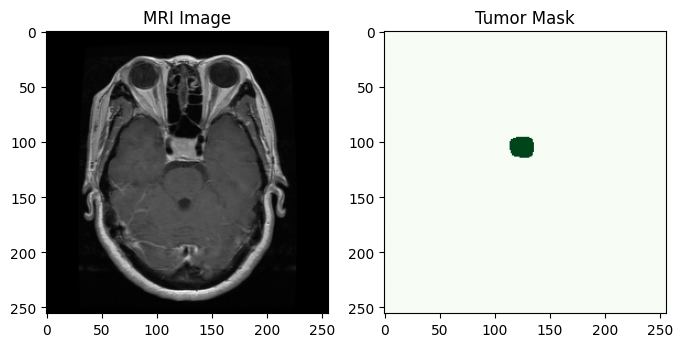

In [10]:
# visualization
import matplotlib.pyplot as plt

def show_sample(index=0):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(X[index, :, :, 0], cmap='gray')
    axs[0].set_title("MRI Image")
    axs[1].imshow(y[index, :, :, 0], cmap='Greens')
    axs[1].set_title("Tumor Mask")
    plt.show()

show_sample(10)

In [13]:
!pip install tensorflow

In [7]:
# U-Net Model Building

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def unet(img_size=128, channels=1):
    input_shape = (img_size, img_size, channels)
    inputs = Input(input_shape)

    # Encoder (1 conv per block)
    c1 = Conv2D(8, 3, activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(16, 3, activation='relu', padding='same')(p1)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(32, 3, activation='relu', padding='same')(p2)
    p3 = MaxPooling2D()(c3)

    # Bottleneck
    c4 = Conv2D(64, 3, activation='relu', padding='same')(p3)

    # Decoder (1 conv per block)
    u5 = Conv2DTranspose(32, 2, strides=2, padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(32, 3, activation='relu', padding='same')(u5)

    u6 = Conv2DTranspose(16, 2, strides=2, padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(16, 3, activation='relu', padding='same')(u6)

    u7 = Conv2DTranspose(8, 2, strides=2, padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(8, 3, activation='relu', padding='same')(u7)

    outputs = Conv2D(1, 1, activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model


In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model = unet()
model.summary()

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(),
    metrics=['accuracy', MeanIoU(num_classes=2)]
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=10
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │         80 │ input_layer_1[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64, 8) │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │      1,168 │ max_pooling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │      4,640 │ max_pooling2d_5[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 16, 16,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 32, 32,    │      8,224 │ conv2d_22[0][0]   │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_21[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │     18,464 │ concatenate_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 64, 64,    │      2,064 │ conv2d_23[0][0]   │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 32)               │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │      4,624 │ concatenate_5[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 128, 128,  │        520 │ conv2d_24[0][0]   │
│ (Conv2DTranspose)   │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 16)               │            │ conv2d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 128, 128,  │      1,160 │ concatenate_6[0]

 Total params: 59,449 (232.22 KB)

 Trainable params: 59,449 (232.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 95s 336ms/step - accuracy: 0.9825 - loss: 0.4339 - mean_io_u_1: 0.4914 - val_accuracy: 0.9826 - val_loss: 0.0858 - val_mean_io_u_1: 0.4913
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 144s 345ms/step - accuracy: 0.9828 - loss: 0.0794 - mean_io_u_1: 0.4914 - val_accuracy: 0.9826 - val_loss: 0.0738 - val_mean_io_u_1: 0.4913
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 138s 331ms/step - accuracy: 0.9831 - loss: 0.0723 - mean_io_u_1: 0.4916 - val_accuracy: 0.9826 - val_loss: 0.0716 - val_mean_io_u_1: 0.4913
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 145s 343ms/step - accuracy: 0.9829 - loss: 0.0700 - mean_io_u_1: 0.4915 - val_accuracy: 0.9826 - val_loss: 0.0698 - val_mean_io_u_1: 0.4913
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 139s 332ms/step - accuracy: 0.9826 - loss: 0.0690 - mean_io_u_1: 0.4913 - val_accuracy: 0.9826 - val_loss: 0.0685 - val_mean_io_u_1: 0.4913
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 144s 340ms/step - accuracy: 0.9832 - loss: 0.0662 - mean_io_u

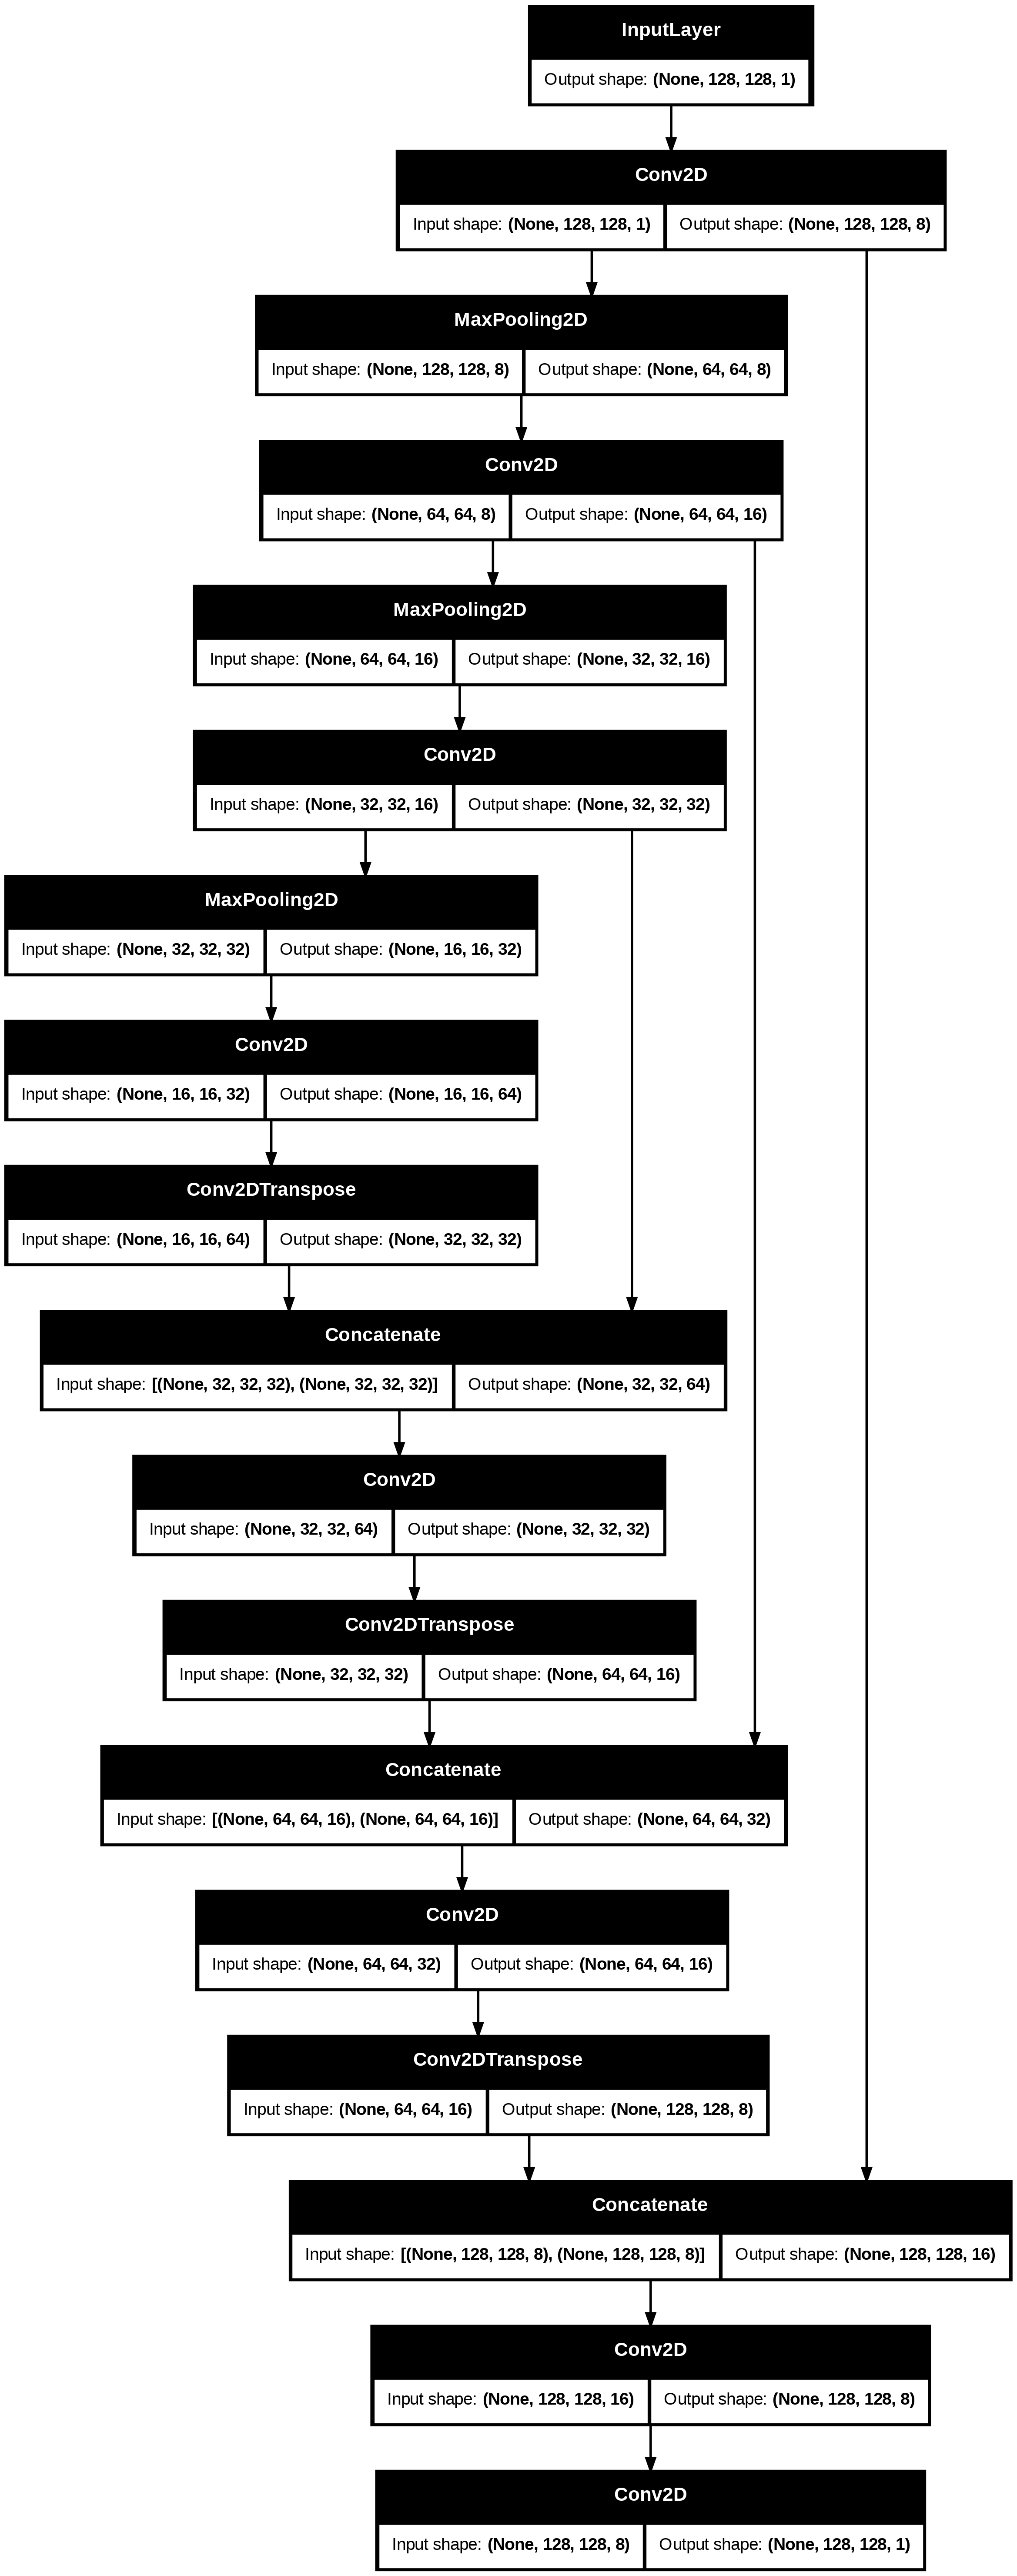

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

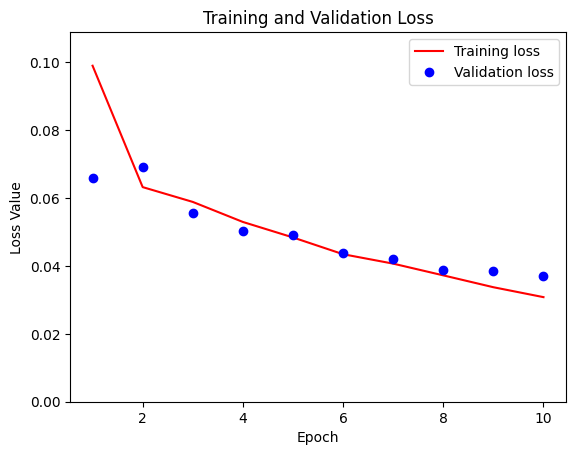

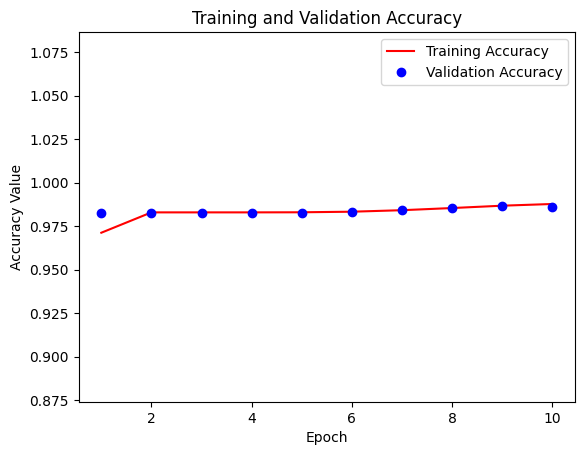

In [21]:
# evaluation & visualization
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Correct the epochs variable to match the length of the loss and accuracy lists
epochs_range = range(1, len(loss) + 1)


plt.figure()
plt.plot(epochs_range, loss, 'r', label='Training loss')
plt.plot(epochs_range, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, max(max(loss), max(val_loss)) * 1.1]) # Adjust y-limit based on actual loss values
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_range, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, 'bo', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([min(min(accuracy), min(val_accuracy)) * 0.9, max(max(accuracy), max(val_accuracy)) * 1.1]) # Adjust y-limit based on actual accuracy values
plt.legend()
plt.show()

# CT/ MRI segmentation results

In [20]:
# CNN Model

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose
from tensorflow.keras.models import Sequential

layers = [
    Conv2D(input_shape=[256, 256, 1],
           filters=100,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu,
           name="Conv1"),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=200,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=2,
           kernel_size=1,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2DTranspose(filters=2, kernel_size=31, strides=16, padding="same")
]

model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=10
)

Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 112s 406ms/step - accuracy: 0.9331 - loss: 0.1874 - val_accuracy: 0.9826 - val_loss: 0.0659
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 140s 400ms/step - accuracy: 0.9831 - loss: 0.0635 - val_accuracy: 0.9826 - val_loss: 0.0691
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 142s 399ms/step - accuracy: 0.9830 - loss: 0.0606 - val_accuracy: 0.9826 - val_loss: 0.0556
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 141s 397ms/step - accuracy: 0.9827 - loss: 0.0547 - val_accuracy: 0.9826 - val_loss: 0.0504
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 106s 394ms/step - accuracy: 0.9834 - loss: 0.0475 - val_accuracy: 0.9827 - val_loss: 0.0490
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 144s 403ms/step - accuracy: 0.9832 - loss: 0.0444 - val_accuracy: 0.9833 - val_loss: 0.0438
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 138s 390ms/step - accuracy: 0.9842 - loss: 0.0402 - val_accuracy: 0.9842 - val_loss: 0.0421
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 141s 388ms/step - accuracy: 0.9848 -

In [27]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 128, 128, 100)  │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 32, 32, 200)    │       500,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 16, 16, 300)    │       540,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 16, 16, 300)    │       810,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 16, 16, 2)      │           602 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 256, 256, 2)    │         3,846 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,573,546 (21.26 MB)

 Trainable params: 1,857,848 (7.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,715,698 (14.17 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


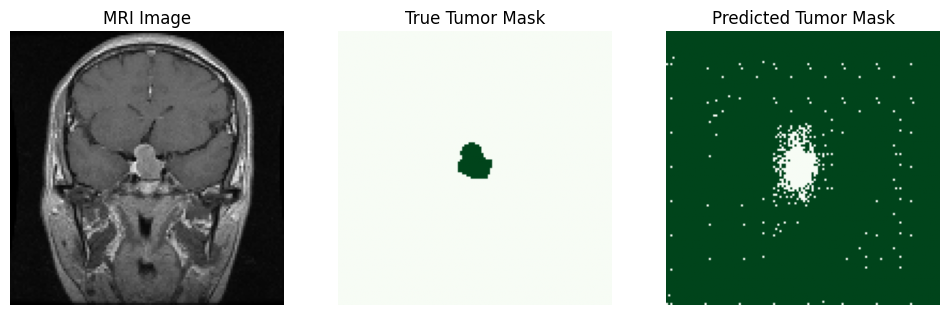

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


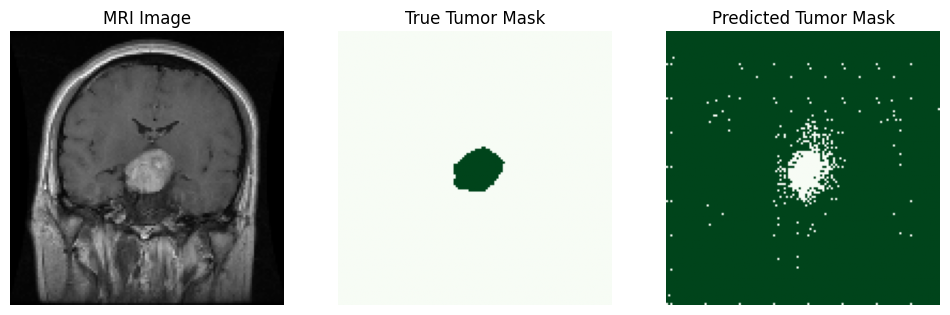

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


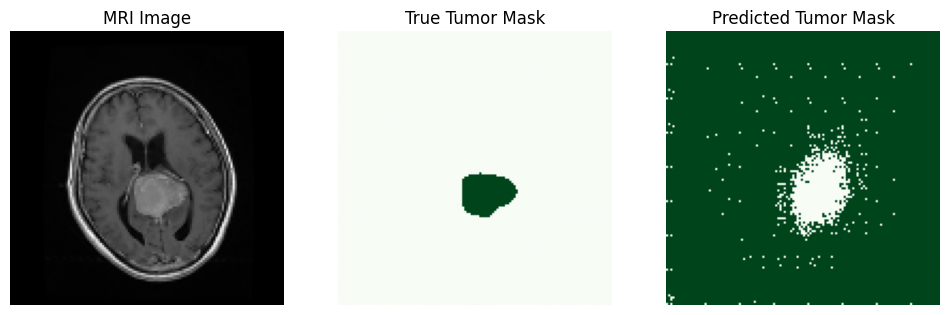

In [25]:
# Visualize some predictions
import random

def show_prediction(index):
    img = X_test[index]
    true_mask = y_test[index]
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0] # Predict on a single image

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(img[:, :, 0], cmap='gray')
    axs[0].set_title("MRI Image")
    axs[0].axis('off')

    axs[1].imshow(true_mask[:, :, 0], cmap='Greens')
    axs[1].set_title("True Tumor Mask")
    axs[1].axis('off')

    # Apply a threshold to the predicted mask for visualization
    pred_mask_binary = (pred_mask > 0.5).astype(np.uint8)
    axs[2].imshow(pred_mask_binary[:, :, 0], cmap='Greens')
    axs[2].set_title("Predicted Tumor Mask")
    axs[2].axis('off')

    plt.show()

# Show a few random predictions
for _ in range(3):
    index = random.randint(0, len(X_test) - 1)
    show_prediction(index)

### Finish task
The model has been trained and evaluated. The next steps would be to potentially refine the model architecture, hyperparameters, or training data to improve performance further, or to deploy the model for inference on new data.